In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import random

#functions 
from functions import *

In [2]:
# def num_paths2(g, i, j):
#     #i,j = name of nodes
#     #number of paths length 2 between node i and node j in graph g
#     #Note: this function covers cases when g.nodes() is not in ascedign order
    
#     A = nx.adjacency_matrix(g)#ordering of rows/columns is by G.nodes(), not necessarily ascending
#     A = A.todense()
    
#     A_sq = np.matmul(A,A) #(A^2)_{ij} = how many paths length 2 betwenn node i and j
    
#     #what's the index of node i and node j in g.nodes?
#     ns = list(g.nodes())
#     ind_i = ns.index(i)
#     ind_j = ns.index(j)
    
#     return A_sq[ind_i, ind_j]

In [12]:
# import itertools

# def num_2seed_triangles(g, seeds):
#     #how many triangles of (target a) - (target b)
#     #                          \          /
#     #                          (untargeted)
#     count = 0
#     for comb in itertools.combinations(seeds, 2): #for each size-2 combination of seeds (targets)
#         #print(comb)

#         #how to identify such a triangle:

#         #the seeds are connected
#         if g.has_edge(comb[0],comb[1]):
#             #AND There is a path length 2 through an UNTARGETED node.

#             #we have to exclude paths through another TARGET node. 
#             # To do this: get subgraph which removes all other target nodes except comb[0] and comb[1]
#             other_seeds = [seed for seed in seeds if seed not in [comb[0],comb[1]]] 
#             sub_nodes = [node for node in g.nodes() if node not in other_seeds] #remove the other seeds
#             #print(other_seeds)
#             gsub = g.subgraph(sub_nodes)
#             count += num_paths2(gsub,comb[0],comb[1])
    
#     return count

# #note: to get the number of connected triplets where 
# #                      (target a)  (target b)
# #                          \          /
# #                          (untargeted)
# #just need to remove the check that the seeds are connected

## faster versions

In [66]:
# def num_paths3(g, i, j):
#     #i,j = name of nodes
#     #number of paths length 3 between node i and node j in graph g
#     #Note: this function covers cases when g.nodes() is not in ascedign order
    
#     A = nx.adjacency_matrix(g)#ordering of rows/columns is by G.nodes(), not necessarily ascending
#     A = A.todense()
    
#     A_sq = np.matmul(A,A)
#     A_cubed = np.matmul(A_sq,A)
    
#     #what's the index of node i and node j in g.nodes?
#     ns = list(g.nodes())
#     ind_i = ns.index(i)
#     ind_j = ns.index(j)
    
#     return A_cubed[ind_i, ind_j]

# def num_2seed_trianglesV2(g, seeds):
#     #how many triangles of (target a) - (target b)
#     #                          \          /
#     #                          (untargeted)
#     count = 0
#     nonseeds = [n for n in g.nodes if n not in seeds]
    
#     for ns in nonseeds:
#         gsub = g.subgraph(seeds + [ns])
#         count += int(num_paths3(gsub,ns,ns)/2)
        
#         #each path3 is counted twice: as {i,j,k,i} and {i,k,j,i}
   
#     return count

# def two_seed_tranV2(g, seeds):
#     return(num_2seed_trianglesV2(g, seeds) / num_con_triples(g))

## some checks on simple graphs

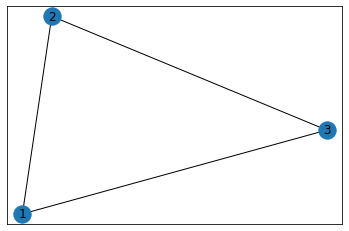

In [70]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3])
gg.add_edge(1, 2)
gg.add_edge(1, 3)
gg.add_edge(2, 3)
nx.draw_networkx(gg)

In [75]:
seeds = [1,3]
print(num_2seed_triangles(gg,seeds))
num_2seed_trianglesV2(gg, seeds)

1


1

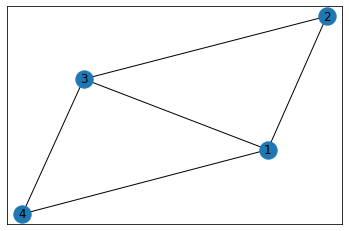

In [76]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4)])

nx.draw_networkx(gg)

In [77]:


seeds = [1,3]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg, seeds))

seeds = [1,4]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg, seeds))

2
2
1
1


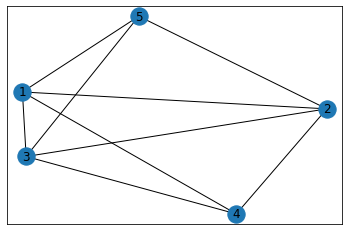

In [93]:
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4,5])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4), (4,2), (5,1), (5,2), (5,3)])

nx.draw_networkx(gg)

In [94]:


seeds = [4,5]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

seeds = [5,1]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

seeds = [5,1,2]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

0
0
2
2
4
4


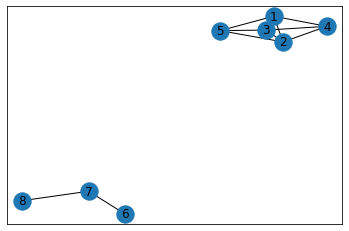

In [95]:
#EDGE CASE: more than one connected component
gg = nx.Graph()
gg.add_nodes_from([1,2,3,4,5, 6,7,8])
gg.add_edges_from([(1, 2), (1, 3), (2, 3), (1,4), (3,4), (4,2), (5,1), (5,2), (5,3),
                  (6,7), (7,8)])

nx.draw_networkx(gg)

In [97]:
#SHOULD BE SAME AS ABOVE

seeds = [4,5]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

seeds = [5,1]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

seeds = [5,1,2]
print(num_2seed_triangles(gg,seeds))
print(num_2seed_trianglesV2(gg,seeds))

0
0
2
2
4
4


## The idea of a measure

Recall: the transitivity was 
$$3\frac{\#triangles}{\#connected triples}$$

*Note*: (see first week lec)

a connected triple (i)-(j)-(k)
contains two paths length 2: {i,j,k}, {k,j,i}

From our discussions (also see original seeding paper), the probability of a nontargeted node getting the innovation is affected by two things:

- the number of alters that are targeted
- whether two targeted alters are themselves friends

In [ ]:

# (target)  (not target)        (target)  (target)           (target) - (target)
#    \            /        <        \        /        <         \           /
#         (x)                           (x)                           (x)


This triangle property is a possible mechanism to explain the probability of a innovation spreading. the strongest type of influence would come from the third type of connected triple (in code, called `2seed_triangles`)

Some way of measuring the prevlance of such `2seed_triangles`, might be indicative of the success of a seeding method. But how to measure? 

- $$3 \frac{\# 2seed triangles}{\#connected triples}$$

then this is like a 'harsher' version of the transitivity coefficient, where we're only counting **triangles with 2 seeds as vertices.** 

This has a nice relationship wtih the transitivity coefficient in that their ratio

$$3 \frac{\# 2seed triangles}{\#connected triples}/ 3\frac{\#triangles}{\#connected triples} = 
\frac{\# 2seed triangles}{\# triangles}$$

is the proportion of *actual triangles* that are `2seed_triangles`. 

Note this ratio will always $<1$ since `2seed_triangles` are a subset of triangles.  

In [26]:
# def num_con_triples(g):
#     #solve for #connected triples from the transitivity formula:
#     # 3*num_triangles/transitivity = #connected triples
#     num_triangles = sum(nx.triangles(g).values()) / 3 #triple-counting each triangle
#     trans = nx.transitivity(g)
    
#     return (3*num_triangles/trans)

In [27]:
# def two_seed_tran(g, seeds):
#     return(num_2seed_triangles(g, seeds) / num_con_triples(g))

## testing on karate club

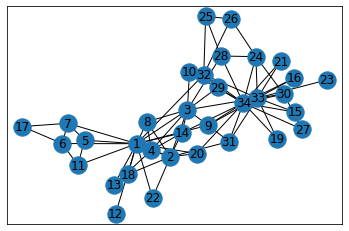

In [78]:
G=nx.read_adjlist("data/karate_edges_77.txt",nodetype=int)
nx.draw_networkx(G,pos=nx.spring_layout(G))

In [79]:
#kinda annoying to do it this way, but it will avoid copying over large objects when over repated networks

#create empty dataframe
nsamp = 200
big_dat = pd.DataFrame({"seeding method": ['random']*nsamp + ['friend']*nsamp + ['pair']*nsamp})

In [90]:
#for a graph g, simulate seeds nsamp times. Each time, calculate the transiticity measures
#name: string for network name
# def sim_2seed_transitivity(g, p, nsamp = 200):
#     random_2tran = []
#     friend_2tran = []
#     pair_2tran = []
    

#     for i in range(0,nsamp):
#         random_seeds = get_seeds(g, p, 'random')
#         friend_seeds = get_seeds(g, p, 'friend')
#         pair_seeds = get_seeds(g, p, 'pair')

#         random_2tran.append(two_seed_tranV2(g, random_seeds))
#         friend_2tran.append(two_seed_tranV2(g, friend_seeds))
#         pair_2tran.append(two_seed_tranV2(g, pair_seeds))
    
#     #(nsamp x 1 vector, ...)
#     return (random_2tran, friend_2tran, pair_2tran)

In [56]:
#append results as columns
(rtran, ftran, ptran) = sim_2seed_transitivity(G, p, nsamp)
big_dat["2-seed transitivity"] = rtran + ftran + ptran
big_dat['tran'] = nx.transitivity(G)

In [48]:
import plotly.express as px
fig = px.box(big_dat, x="seeding method", y="2-seed transitivity")
fig.show()

It is expected that the friend method will give higher `2-seed transitivity` than pair method. 
By the frienship paradox, both seeds in the friend method will have higher degree than the original egos.


But in the pair method, the ego in the pair (on average) has lower degree than the alter. And intuitively, we know that nodes with higher degrees are more likely to be involved in triangles (in small world networks for example, triangles mostly form around the hubs). So the friend method would likely have seeds involved in more triangles. 

## on the empirical networks

on village 1, the faster algorithm shoudl take 40 seconds. The old algorithm took 1 min 30. 

In [6]:
#Banerjee vilages
cross_sec = pd.read_stata("banerjee12_data/datav4.0/Stata Replication/data/cross_sectional.dta")
villages = [str(int(vil)) for vil in cross_sec['village']]
print(villages)

['1', '2', '3', '4', '6', '9', '12', '15', '19', '20', '21', '23', '24', '25', '29', '31', '32', '33', '36', '39', '42', '43', '45', '46', '47', '48', '50', '51', '52', '55', '57', '59', '60', '62', '64', '65', '67', '68', '70', '71', '72', '73', '75']


In [7]:
%%time

#take smaller subset. on village 1 this shoudl take around 40 sec
nsamp = 50
big_dat = pd.DataFrame({"seeding method": ['random']*nsamp + ['friend']*nsamp + ['pair']*nsamp})

for vil in villages:
    
    path = 'banerjee12_data/datav4.0/Data/1. Network Data/Adjacency Matrices/adj_allVillageRelationships_HH_vilno_{}.csv'.format(vil)
    adj_mat = pd.read_csv(path,header = None)
    current_g = nx.from_pandas_adjacency(adj_mat)
    print(vil)
    
    #append results as columns
    ( rtran, ftran, ptran) = sim_2seed_transitivity(current_g, p = 0.2, nsamp = nsamp)
    big_dat["2tran" + " vil{}_{}".format(vil,nx.number_of_nodes(current_g))] = rtran + ftran + ptran
    
    #big_dat['tran'+ " vil {}".format(vil)] = nx.transitivity(current_g)

1
2
3
4
6
9
12
15
19
20
21
23
24
25
29
31
32
33
36
39
42
43
45
46
47
48
50
51
52
55
57
59
60
62
64
65
67
68
70
71
72
73
75
CPU times: user 38min 18s, sys: 14.8 s, total: 38min 32s
Wall time: 40min 34s


In [8]:
big_dat

,seeding method,2tran vil1_182,2tran vil2_195,2tran vil3_292,2tran vil4_239,2tran vil6_114,2tran vil9_207,2tran vil12_175,2tran vil15_171,2tran vil19_204,...,2tran vil62_190,2tran vil64_257,2tran vil65_297,2tran vil67_193,2tran vil68_153,2tran vil70_205,2tran vil71_298,2tran vil72_223,2tran vil73_174,2tran vil75_172
0,random,0.005836,0.007828,0.003424,0.003715,0.007079,0.003728,0.008706,0.004686,0.003193,...,0.006273,0.006832,0.011124,0.009409,0.003992,0.013015,0.007663,0.006693,0.006261,0.006735
1,random,0.003428,0.006749,0.004584,0.003238,0.007895,0.009411,0.007059,0.007105,0.008541,...,0.004351,0.004212,0.008541,0.005898,0.006448,0.007685,0.005955,0.004151,0.005509,0.014662
2,random,0.008607,0.002025,0.003369,0.002857,0.009529,0.005561,0.004353,0.005971,0.006164,...,0.005970,0.005615,0.006952,0.012147,0.006346,0.007892,0.011310,0.003269,0.004946,0.010252
3,random,0.005179,0.002834,0.003866,0.004096,0.006262,0.006661,0.006118,0.004006,0.005793,...,0.009916,0.004118,0.004966,0.006811,0.004197,0.006280,0.010248,0.006797,0.005697,0.006497
4,random,0.002918,0.002295,0.003203,0.005524,0.008984,0.005928,0.002588,0.004762,0.005570,...,0.007285,0.008610,0.006058,0.010813,0.005425,0.009379,0.005678,0.005137,0.005885,0.012338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,pair,0.011963,0.009313,0.010272,0.004286,0.015246,0.013322,0.005412,0.003855,0.011734,...,0.012142,0.012635,0.011786,0.011375,0.012180,0.013801,0.010848,0.009443,0.015276,0.015496
146,pair,0.008753,0.010393,0.009333,0.005715,0.012524,0.004461,0.008471,0.009448,0.012105,...,0.011737,0.010295,0.006224,0.013341,0.013408,0.013553,0.015142,0.011363,0.010142,0.011444
147,pair,0.012547,0.012822,0.009168,0.006572,0.011707,0.008433,0.010706,0.006878,0.006981,...,0.011535,0.008423,0.010627,0.008566,0.014227,0.011611,0.015003,0.011259,0.009453,0.014900
148,pair,0.016267,0.005399,0.008395,0.008001,0.007351,0.013139,0.009529,0.006349,0.007724,...,0.010321,0.009733,0.011322,0.012428,0.008700,0.008594,0.009417,0.009858,0.011770,0.014602


In [9]:
big_dat.to_csv("big_dat_v.csv", index = False)

for plots, see `transitivity_plot.Rmd`